<a href="https://colab.research.google.com/github/ldsbalu/Balu-Portfolio/blob/main/Final_project_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import re
import string
from string import digits
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from flask import Flask, request, jsonify

In [8]:

project_path = "/content/english_telugu_data.txt"

In [9]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [10]:
def clean_text(text, is_telugu=False):
    text = text.lower().strip()
    if not is_telugu:
        text = " ".join([contraction_mapping.get(w, w) for w in text.split()])
    text = "".join(c for c in text if c not in set(string.punctuation))
    text = re.sub(r"\d+", "", text)
    if is_telugu:
        text = re.sub(r"[౦-౯]", "", text)
    return " ".join(text.split())

In [6]:
english_sentences, telugu_sentences = [], []
with open(project_path, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split("++++$++++")
        if len(parts) == 2:
            english_sentences.append(clean_text(parts[0]))
            telugu_sentences.append(clean_text(parts[1], is_telugu=True))


In [11]:
data_df = pd.DataFrame({"eng":english_sentences,"tel":telugu_sentences})
data_df.shape

(155798, 2)

In [12]:
data_df.head(10)

,eng,tel
0,his legs are long,అతని కాళ్ళు పొడవుగా ఉన్నాయి
1,who taught tom how to speak french,టామ్ ఫ్రెంచ్ మాట్లాడటం ఎలా నేర్పించారు
2,i swim in the sea every day,నేను ప్రతి రోజు సముద్రంలో ఈత కొడతాను
3,tom popped into the supermarket on his way hom...,టామ్ కొంచెం పాలు కొనడానికి ఇంటికి వెళ్ళేటప్పుడ...
4,smoke filled the room,పొగ గదిని నింపింది
5,tom and mary understood each other,టామ్ మరియు మేరీ ఒకరినొకరు అర్థం చేసుకున్నారు
6,many men want to be thin too,చాలా మంది పురుషులు కూడా సన్నగా ఉండాలని కోరుకుం...
7,we need three cups,మాకు మూడు కప్పులు అవసరం
8,i warned tom not to come here,టామ్‌ను ఇక్కడికి రానివ్వమని హెచ్చరించాను
9,you two may leave,మీరిద్దరూ వెళ్ళవచ్చు


In [13]:
def build_vocab(sentences):
    counter = Counter([word for s in sentences for word in s.split()])
    vocab = {"<pad>": 0, "<unk>": 1, "<sos>": 2, "<eos>": 3}
    for word in counter: vocab[word] = len(vocab)
    return vocab

eng_vocab = build_vocab(data_df["eng"])
tel_vocab = build_vocab(data_df["tel"])
idx2tel = {v: k for k, v in tel_vocab.items()}

In [14]:
MAX_LEN = 20
def encode(sentence, vocab):
    tokens = [vocab["<sos>"]] + [vocab.get(w, vocab["<unk>"]) for w in sentence.split()] + [vocab["<eos>"]]
    return F.pad(torch.tensor(tokens), (0, max(0, MAX_LEN - len(tokens))), value=vocab["<pad>"])[:MAX_LEN]

In [15]:
X = torch.stack([encode(s, eng_vocab) for s in data_df["eng"]])
Y = torch.stack([encode(s, tel_vocab) for s in data_df["tel"]])

# Split data into 80% Train, 20% Validation
dataset = TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hid_dim, batch_first=True)
    def forward(self, src):
        _, (hidden, cell) = self.lstm(self.embedding(src))
        return hidden, cell



In [17]:
class Decoder(nn.Module):
    def __init__(self, output_vocab_size, embed_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(output_vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.fc_out = nn.Linear(hidden_dim, output_vocab_size)

    def forward(self, input_token, hidden, cell):

        input_token = input_token.unsqueeze(1)
        embedded = self.embedding(input_token)
        outputs, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        logits = self.fc_out(outputs.squeeze(1))
        return logits, hidden, cell

In [18]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder, self.decoder = encoder, decoder
    def forward(self, src, trg, tf_ratio=0.5):
        batch_size, trg_len = trg.shape[0], trg.shape[1]
        outputs = torch.zeros(batch_size, trg_len, len(tel_vocab)).to(device)
        hidden, cell = self.encoder(src)
        input = trg[:, 0]
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t] = output
            input = trg[:, t] if torch.rand(1) < tf_ratio else output.argmax(1)
        return outputs

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2Seq(Encoder(len(eng_vocab), 256, 512), Decoder(len(tel_vocab), 256, 512)).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=0)



In [20]:
train_losses, val_losses = [], []
epochs = 10

for epoch in range(1, epochs + 1):
    # Training Phase
    model.train()
    epoch_train_loss = 0
    for src, trg in train_loader:
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        loss = criterion(output[:, 1:].reshape(-1, len(tel_vocab)), trg[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    # Validation Phase
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for src, trg in val_loader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, tf_ratio=0)
            loss = criterion(output[:, 1:].reshape(-1, len(tel_vocab)), trg[:, 1:].reshape(-1))
            epoch_val_loss += loss.item()

    avg_train = epoch_train_loss / len(train_loader)
    avg_val = epoch_val_loss / len(val_loader)
    train_losses.append(avg_train)
    val_losses.append(avg_val)

    print(f"Epoch {epoch:02} | Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f}")



Epoch 01 | Train Loss: 5.0345 | Val Loss: 4.0506
Epoch 02 | Train Loss: 3.0376 | Val Loss: 3.1711
Epoch 03 | Train Loss: 2.0105 | Val Loss: 2.8760
Epoch 04 | Train Loss: 1.3703 | Val Loss: 2.7952
Epoch 05 | Train Loss: 0.9619 | Val Loss: 2.8145
Epoch 06 | Train Loss: 0.7160 | Val Loss: 2.8671
Epoch 07 | Train Loss: 0.5504 | Val Loss: 2.9478
Epoch 08 | Train Loss: 0.4356 | Val Loss: 3.0253
Epoch 09 | Train Loss: 0.3462 | Val Loss: 3.0763
Epoch 10 | Train Loss: 0.2856 | Val Loss: 3.1506


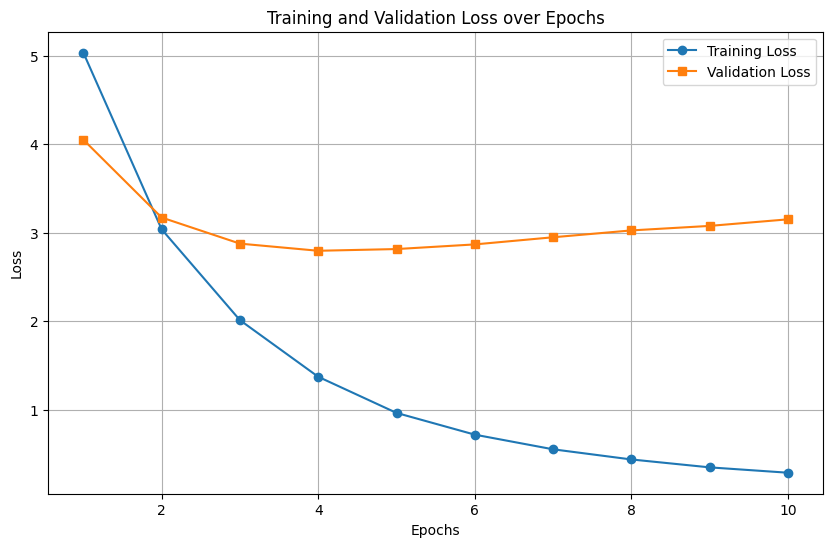

In [21]:

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='s')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
def translate(sentence):
    model.eval()
    with torch.no_grad():
        src = encode(clean_text(sentence), eng_vocab).unsqueeze(0).to(device)
        hidden, cell = model.encoder(src)
        input = torch.tensor([tel_vocab["<sos>"]]).to(device)
        res = []
        for _ in range(MAX_LEN):
            output, hidden, cell = model.decoder(input, hidden, cell)
            input = output.argmax(1)
            if input.item() == tel_vocab["<eos>"]: break
            res.append(idx2tel.get(input.item(), "<unk>"))
    return " ".join(res)


    return " ".join(res)

# Final Output: Shows both English and Telugu
test_sentence = "how are you"
translation = translate(test_sentence)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [26]:
print("-" * 30)
print(f"English (Input): {test_sentence}")
print(f"Telugu (Output):  {translation}")
print("-" * 30)

------------------------------
English (Input): how are you
Telugu (Output):  ఎలా ఎలా ఉన్నారు
------------------------------


In [28]:
torch.save(model.state_dict(), 'translation_model.pth')
import pickle
with open('vocabs.pkl', 'wb') as f:
    pickle.dump({'eng': eng_vocab, 'tel': tel_vocab, 'idx2tel': idx2tel}, f)

In [29]:
from google.colab import files
files.download("translation_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
def translate_sentence(model, sentence, eng_vocab, tel_vocab, device, max_len=20):
    model.eval()

    # 1. Clean and Tokenize
    processed_text = clean_text(sentence) # Uses your clean_text function
    tokens = [eng_vocab.get(w, eng_vocab["<unk>"]) for w in processed_text.split()]
    tokens = [eng_vocab["<sos>"]] + tokens + [eng_vocab["<eos>"]]

    # 2. Convert to Tensor
    src_tensor = torch.LongTensor(tokens).unsqueeze(0).to(device)

    # 3. Predict using Encoder-Decoder
    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor)

    trg_indices = [tel_vocab["<sos>"]]
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indices[-1]]).to(device)
        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)

        pred_token = output.argmax(1).item()
        trg_indices.append(pred_token)

        if pred_token == tel_vocab["<eos>"]:
            break


    translated_words = [idx2tel.get(idx, "<unk>") for idx in trg_indices]

    # Remove special tokens for the final output
    return " ".join([word for word in translated_words if word not in ["<sos>", "<eos>", "<pad>"]])

In [ ]:
from flask import Flask, request, jsonify
from google.colab.output import eval_js

app = Flask(__name__)

@app.route("/translate", methods=['POST'])
def translate():
    data = request.get_json(force=True)
    eng_text = data.get("text", "")

    if not eng_text:
        return jsonify({"error": "Missing 'text' field"}), 400

    try:

        telugu = translate_sentence(model, eng_text, eng_vocab, tel_vocab, device)
        return jsonify({"input": eng_text, "translation": telugu})
    except Exception as e:
        return jsonify({"error": str(e)}), 500

if __name__ == "__main__":

    print("Click the link below to access the API:")
    proxy_url = eval_js('google.colab.kernel.proxyPort(5000)')
    print(f"{proxy_url}translate")

    app.run(host="0.0.0.0", port=5000)

Click the link below to access the API:
https://5000-gpu-a100-hm-2cgilobfumrl1-c.asia-southeast1-2.prod.colab.devtranslate
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
